**(minimum) path integral Monte Carlo for harmonic oscillators**

1. every particle is distinguishable (Boltzmons)
2. every particle has the same attributes (mass, charge etc.)
3. every particle is trapped by the same (harmonic) potential centered at the origin 
4. open boundary condition
5. three dimensional space

In [1]:
using PyPlot

In [2]:
type Path
    # a configuration sampled in PIMC
    
    # number of imaginary time slices
    num_slices   ::Int64 
    # number of particles
    num_particles::Int64 
    # !!!! assume all particles are identical
    mass :: Float64 
    lambda::Float64 # 1/(2m) i.e. prefactor in kinetic operator
    
    # configration (positions of all particles at all time slices)
    #  Rti[t,i,:] is the 3D-vector of particle i's location at imaginary time t
    Rti::Array{Float64,3}
    # Rti[t,:,:] contains the positions of all particles at time slice t
    # Rti[:,i,:] contains the positions of particle i at all time slices
    # the last index is for x,y,z
    
    function Path(M::Integer,N::Integer;mass=1.0)
        num_slices = M
        num_particles = N
        Rti = rand(num_slices,num_particles,3)
        lambda = 0.5/mass
        
        new(num_slices,num_particles,mass,lambda,Rti)
    end
end

1. type instead of class. 
2. function with type name is constructor. 
3. new() allocates memory. 
4. default parameters are separated from inputs by ;

In [3]:
function visualize(path::Path;projection::ASCIIString="xy")
    
    # project the 3D particle positions onto 2 dimensions
    proj = split(projection,"")
    dim_map = Dict("x"=>1,"y"=>2,"z"=>3)
    xid = dim_map[proj[1]]
    yid = dim_map[proj[2]]
    for iatom=1:path.num_particles
        x = path.Rti[:,iatom,xid]
        y = path.Rti[:,iatom,yid]
        x = reshape(x,length(x))
        y = reshape(y,length(y))
        # each ring should connect back to itself
        push!(x,x[1])
        push!(y,y[1])
        plot(x,y,"x--",mew=2,label=@sprintf("particle %d",iatom) )
        for j=1:length(x)-1
            annotate("slice $j", xy=(x[j],y[j]) )
        end
    end
    legend()
    
end

visualize (generic function with 1 method)

1. dctionary exists
2. (by convention) functions that change arrays end with ! 
3. bash like substitution "var=$var"

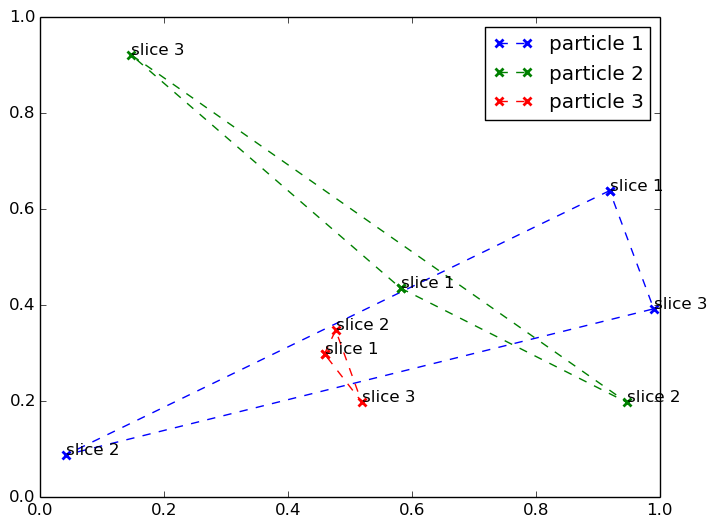

PyObject <matplotlib.legend.Legend object at 0x7f005a943a90>

In [4]:
path = Path(3,3)
visualize(path)

1. type instead of class
2. subtype allow compositon

In [5]:
abstract Potential
abstract OneBodyPotential <: Potential
type NoOneBodyPotential <: OneBodyPotential
end
function one_body_potential(pot::NoOneBodyPotential,
    path::Path,t::Integer)
  return 0.0
end

one_body_potential (generic function with 1 method)

In [6]:
type HarmonicPotential <: OneBodyPotential
    
    omega  :: Float64 # Eh = 1/2 m omega^2 dx^2
    function HarmonicPotential(w::Float64)
        omega = w
        new(omega)
    end
end
function one_body_potential(pot::HarmonicPotential,
  path::Path,t::Integer)
  # harmonic potential experienced by time slice t of a path
  potential = 0.5*path.mass*pot.omega^2*vecnorm(path.Rti[t,:,:])^2
  return potential
end

one_body_potential (generic function with 2 methods)

1. multiple dispatch: define function to act on types rather than methods for each class.
2. 

In [7]:
function kinetic_energy(path::Path,tau::Real)
    kinetic = 0.0

    inverse_four_lambda_tau2 = 1/(4.0*path.lambda*tau^2)
    
    for t=1:path.num_slices
        # last bead connects back to the first
        t1 = t==path.num_slices ? 1:t+1
        kinetic -= inverse_four_lambda_tau2*
          vecnorm(path.Rti[t,:,:]-path.Rti[t1,:,:])^2
    end
    kinetic /= float(path.num_slices)
    kinetic += 3.*path.num_particles/2/tau

    # return the kinetic energy of the path, averaged over all time slices
    return kinetic
end
function potential_energy( path::Path;
  pot1::OneBodyPotential=NoOneBodyPotential() )

    potential = 0.0

    for t=1:path.num_slices
        # last bead connects back to the first
        t1 = t==path.num_slices ? 1:t+1

        potential += one_body_potential(pot1,path,t)
    end

    # return the potential energy of the path, averaged over all time slices
    return potential/float(path.num_slices)
end

potential_energy (generic function with 1 method)

In [8]:
function primitive_action(path::Path, tau::Float64;
  pot1::OneBodyPotential = NoOneBodyPotential() )
    # calculate kinetic action and potential action as 
    #  integral of the Lagrangian over time
    #   tau is time step

    kinetic_action = 0.0
    potential_action = 0.0
    for t=1:path.num_slices
        # last bead connects back to the first
        t1 = t==path.num_slices ? 1:t+1

        lambda = path.lambda
        # calculate kinetic action
        kinetic_action += vecnorm(path.Rti[t,:,:]-path.Rti[t1,:,:])^2/(4.*lambda*tau)
        kinetic_action += 3.*path.num_particles/2*log(4*pi*lambda*tau)

        # calculate potential action: explicitly symmetrize
        potential_action += 0.5*tau*(
          one_body_potential(pot1,path,t)+one_body_potential(pot1,path,t1)
        )
    end

    return kinetic_action,potential_action
end

primitive_action (generic function with 1 method)

In [9]:
function single_bead!( # modify path with simple moves
  path::Path,gaussian_width::Float64,
  tau::Float64,nslice::Int64,natom::Int64,
  pot1::OneBodyPotential )

  # observables to accumulate
  attempted_moves = 0
  accepted_moves = 0
  kinetic = 0.0
  potential = 0.0

  # nslice, natom can be different from path.num_slices, path.num_particles
  #  to allow control of part of the path
  for t=1:nslice
      for i=1:natom

        # save old action
        old_kinetic_action, old_potential_action = primitive_action(path,tau,pot1=pot1)
        old_action = old_kinetic_action + old_potential_action

        # make a move
        move_vector = gaussian_width*randn(1,1,3)
        path.Rti[t,i,:] += move_vector

        # find new action
        new_kinetic_action, new_potential_action = primitive_action(path,tau,pot1=pot1)
        new_action = new_kinetic_action + new_potential_action
        
        # accept/reject move and update observables
        if (rand() < exp(-new_action)/exp(-old_action) )
            accepted_moves += 1
        else
            path.Rti[t,i,:] -= move_vector
        end
        attempted_moves += 1

        # accumulate observables
        potential += potential_energy(path,pot1=pot1)
        kinetic += kinetic_energy(path,tau)

      end
  end
  potential /= float(nslice*natom)
  kinetic /= float(nslice*natom)
  return accepted_moves/attempted_moves,kinetic,potential
end

single_bead! (generic function with 1 method)

In [10]:
function pimc(nstep::Int64,mover;
  beta::Float64=100.0,step_ratio::Float64=1.0,
  nslice::Int64=3,natom::Int64=1)

  omega = 1.0
  mass  = 1.0

  # beta is inverse temperature 1/kT
  #  tau is time step
  tau = beta/nslice

  path = Path(nslice,natom,mass=mass)

  # harmonic constraining potential at the origin
  #  same for all particles
  hp = HarmonicPotential(omega)
  # make moves on the order of bead separation
  gaussian_width = step_ratio*sqrt(2*path.lambda*tau)

  # observables to accumulate
  kinetic_trace = zeros(nstep)
  potential_trace = zeros(nstep)

  acceptance = 0.0
  for istep=1:nstep
    Arate,kinetic,potential = mover( path,gaussian_width,tau,nslice,natom,hp )
    acceptance += Arate
    kinetic_trace[istep] = kinetic
    potential_trace[istep] = potential
  end
  acceptance /= nstep
    
  return acceptance,kinetic_trace,potential_trace
end

pimc (generic function with 1 method)

In [11]:
function expectE(beta)
    return 3./2*coth(beta/2.)
end
fineb = linspace(0.5,5.0,100);
finey = map(expectE,fineb);

In [12]:
function autoCorrelation(trace)
    mu = mean(trace)
    s  = std(trace)
    
    sumR = 0.0
    for k=2:length(trace)
        R = 0.0
        
        # calculate autocorrelation
        for t=1:length(trace)-k
            R += (trace[t]-mu)*(trace[t+k]-mu)
        end
        R /= (length(trace)-k)*(s^2.)
        
        # accumulate until R<=0
        if R>0
            sumR += R
        else
            break
        end
    end
    
    return 1+2.*sumR
end

function stdError(trace)
    Neff = length(trace)/autoCorrelation(trace)
    return std(trace)/sqrt(Neff)
end

stdError (generic function with 1 method)

In [13]:
function energy_beta(nstep,nslice,nequil,mover,
    ;beta_min=0.5,beta_step=0.2,beta_max=2.0)
    
    # gather data
    betas = beta_min:beta_step:beta_max
    data = zeros( length(betas) )
    stde = zeros( length(betas) )
    for i=1:length(data)
        beta = betas[i]
        a,T,V = pimc(nstep,mover,
            beta = beta, 
            step_ratio = 0.5, 
            nslice = nslice
        );
        E = T+V

        data[i] = mean(E[nequil:end])
        stde[i] = stdError(E[nequil:end])
    end
    
    # plot 
    fig = figure()
    ax = subplot(111)

    plot(fineb,finey,"--",label="analytic")
    errorbar(betas,data,yerr=stde,fmt="o",label="PIMC")

    ax[:set_xlabel]("\u03b2",fontsize=16)
    ax[:set_ylabel]("Oscillator Energy",fontsize=14)
    ax[:legend]()
end

energy_beta (generic function with 1 method)

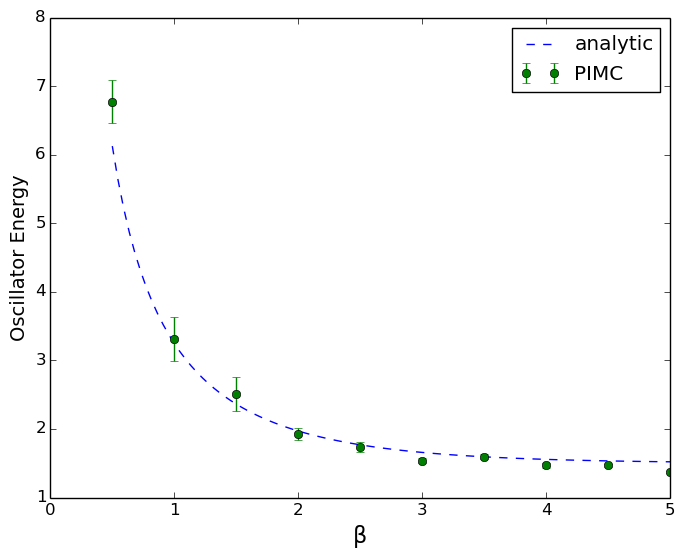

PyObject <matplotlib.legend.Legend object at 0x7f005a501390>

In [14]:
energy_beta(4000,6,10,single_bead!,beta_step=0.5,beta_max=5.0)

In [15]:
nsteps = 100:500:5000;
time = zeros(length(nsteps));
for i = 1:length(nsteps)
    nstep = nsteps[i]
    sec   = @elapsed pimc(nstep,single_bead!,
                beta = 1.0, 
                step_ratio = 0.5, 
                nslice = 3
            )
    time[i] = sec
end

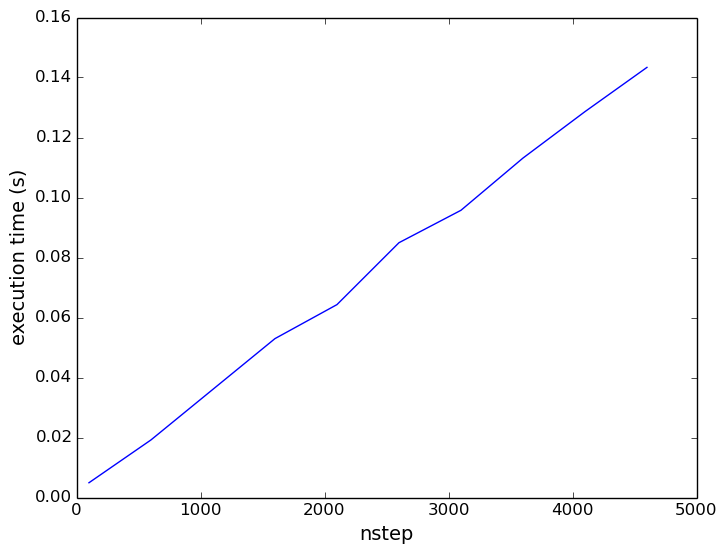

PyObject <matplotlib.text.Text object at 0x7f005a45d490>

In [16]:
fig = figure()
ax = subplot(111)
plot(nsteps,time)
ax[:set_xlabel]("nstep",fontsize=14)
ax[:set_ylabel]("execution time (s)",fontsize=14)

### Summary

The Good:
1. fast
2. simple
3. matlab friendly
4. multiple dispatch
5. master-slave parallization
6. ...

The Bad:
1. few stack overflow entries
2. encapsulation
3. one-based indexing ?!